In [1]:
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import os
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt

In [2]:
tf.test.is_gpu_available()

True

In [3]:
def one_hot_encoder(labellist, nb_classes):
    one_hot = np.zeros([len(labellist), nb_classes])
    for i,l in enumerate(labellist):
        one_hot[i][int(l)-1] = 1
    return one_hot

In [4]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [5]:
ftraindir = r'C:\Users\dhecker\Downloads\dice\train'
ftestdir = r'C:\Users\dhecker\Downloads\dice\valid'

In [6]:
#load training data
dirs = ['d6','d8','d10','d12','d20']
loaded_images = list()
labels = []
for d in dirs:
    files = os.listdir(os.path.join(ftraindir,d))
    for f in files:
        im = image.imread(os.path.join(ftraindir,d,f))
        im = np.resize(im, (64,64,3))
        loaded_images.append(im) #images as LIST
        
        #print('> loaded %s %s' % (f, im.shape))
        
        #set label
        if f[0:2] == 'd4':
            labels.append(1)
        elif f[0:2] == 'd6':
            labels.append(2)
        elif f[0:2] == 'd8':
            labels.append(3)
        elif f[0:3] == 'd10':
            labels.append(4)
        elif f[0:3] == 'd12':
            labels.append(5)
        elif f[0:3] == 'd20':
            labels.append(6)
            
X_train_orig = np.array(loaded_images)
Y_train_orig = labels
print('loaded %i images and set %i labels' % (X_train_orig.shape[0], len(labels)))

loaded 12337 images and set 12337 labels


In [7]:
#load test data
loaded_images = list()
labels = []
for d in dirs:
    files = os.listdir(os.path.join(ftestdir,d))
    for f in files:
        if f[0] == 'd':
            
            im = image.imread(os.path.join(ftestdir,d,f))
            im = np.resize(im, (64,64,3))
            loaded_images.append(im)
        
            #set label
            if f[0:2] == 'd4':
                labels.append(1)
            elif f[0:2] == 'd6':
                labels.append(2)
            elif f[0:2] == 'd8':
                labels.append(3)
            elif f[0:3] == 'd10':
                labels.append(4)
            elif f[0:3] == 'd12':
                labels.append(5)
            elif f[0:3] == 'd20':
                labels.append(6)
            
X_test_orig = np.array(loaded_images)
Y_test_orig = labels
print('loaded %i images and set %i labels' % (X_test_orig.shape[0], len(Y_test_orig)))

loaded 1761 images and set 1761 labels


In [8]:
#flatten
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
del X_train_orig
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
del X_test_orig
#normalize
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
#convert labels to one hot
Y_train = one_hot_encoder(Y_train_orig, 6)
Y_test = one_hot_encoder(Y_test_orig, 6)

In [9]:
Y_train = Y_train.T
Y_test = Y_test.T
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 12337
number of test examples = 1761
X_train shape: (12288, 12337)
Y_train shape: (6, 12337)
X_test shape: (12288, 1761)
Y_test shape: (6, 1761)


In [10]:
#create placeholders
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=[n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, shape=[n_y, None], name = 'Y')
    
    return X,Y

In [11]:
X,Y = create_placeholders(12288,6)

In [12]:
#initialize parameters
def initialize_parameters():
    tf.set_random_seed(42)
    
    W1 = tf.get_variable('W1', [192,12288], initializer=tf.contrib.layers.xavier_initializer(seed = 42))
    b1 = tf.get_variable('b1', [192,1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', [36,192], initializer=tf.contrib.layers.xavier_initializer(seed = 42))
    b2 = tf.get_variable('b2', [36,1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3', [6,36], initializer=tf.contrib.layers.xavier_initializer(seed = 42))
    b3 = tf.get_variable('b3', [6,1], initializer=tf.zeros_initializer())
    
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2,
                  'W3': W3,
                  'b3': b3}
    
    return parameters

In [13]:
#forward propagation
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)
    
    return Z3

In [14]:
#compute cost
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [15]:
#compute cost
def compute_cost_with_l2_reg(Z3, Y, parameters, beta=0.001):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    W3 = parameters['W3']
    W2 = parameters['W2']
    W1 = parameters['W1']
    reg3 = tf.nn.l2_loss(W3)
    reg2 = tf.nn.l2_loss(W2)
    reg1 = tf.nn.l2_loss(W1)
    
    cost = tf.reduce_mean(cost + beta * reg1 + beta * reg2 + beta * reg3)
    
    return cost

In [223]:
tf.reset_default_graph()

with tf.Session() as session:
    X,Y = create_placeholders(12288,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print('Z3 = ' + str(Z3))
    print('cost = ' + str(cost))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)
cost = Tensor("Mean:0", shape=(), dtype=float32)


In [27]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    ops.reset_default_graph()
    tf.set_random_seed(42)
    seed = 3
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X,Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3,Y)
    #cost = compute_cost_with_l2_reg(Z3,Y,parameters,0.001)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        session.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _, minibatch_cost = session.run([optimizer, cost], feed_dict={X: minibatch_X, Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost == True and epoch % 100 == 0:
                print('cost after epoch %i: %f' % (epoch, epoch_cost))
            
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title('learning rate =' + str(learning_rate))
        plt.show()
        
        parameters = session.run(parameters)
        
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print('Train Accuracy:', accuracy.eval({X: X_train, Y: Y_train}))
        print('Test Accuracy:', accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

cost after epoch 0: 2.667590
cost after epoch 100: 1.830252
cost after epoch 200: 1.704259
cost after epoch 300: 1.617368
cost after epoch 400: 1.544502
cost after epoch 500: 1.468823
cost after epoch 600: 1.417658
cost after epoch 700: 1.375701
cost after epoch 800: 1.336610
cost after epoch 900: 1.321862
cost after epoch 1000: 1.277343
cost after epoch 1100: 1.276448
cost after epoch 1200: 1.242390
cost after epoch 1300: 1.216683
cost after epoch 1400: 1.213202


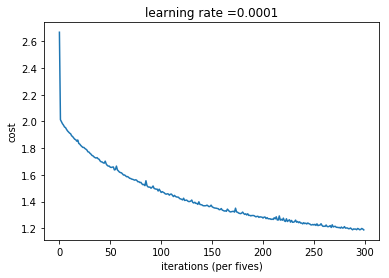

Train Accuracy: 0.65088755
Test Accuracy: 0.6382737


In [30]:
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs=1500, minibatch_size=3085)
#1500 Epochs
#learning rate 0.001
#no reg
#größeres Netz [192,36,6]

cost after epoch 0: 12.326263
cost after epoch 100: 1.890269
cost after epoch 200: 1.851527
cost after epoch 300: 1.829688
cost after epoch 400: 1.768923
cost after epoch 500: 1.710121
cost after epoch 600: 1.621507
cost after epoch 700: 1.540887
cost after epoch 800: 1.519342
cost after epoch 900: 1.381012
cost after epoch 1000: 1.311724
cost after epoch 1100: 1.267803
cost after epoch 1200: 1.225222
cost after epoch 1300: 1.195196
cost after epoch 1400: 1.168836


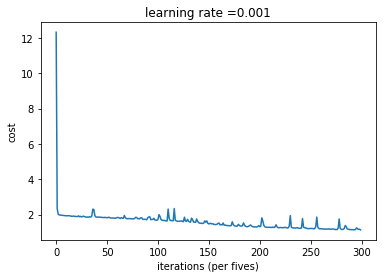

Train Accuracy: 0.65485936
Test Accuracy: 0.6394094


In [29]:
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.001, num_epochs=1500, minibatch_size=3085)
#1500 Epochs
#learning rate 0.001
#no reg
#größeres Netz [192,36,6]

cost after epoch 0: 1.875749
cost after epoch 100: 1.627576
cost after epoch 200: 1.568643
cost after epoch 300: 1.552275
cost after epoch 400: 1.544100
cost after epoch 500: 1.539295
cost after epoch 600: 1.536210
cost after epoch 700: 1.534099
cost after epoch 800: 1.532585
cost after epoch 900: 1.531457
cost after epoch 1000: 1.530593
cost after epoch 1100: 1.529914
cost after epoch 1200: 1.529370
cost after epoch 1300: 1.528927
cost after epoch 1400: 1.528560


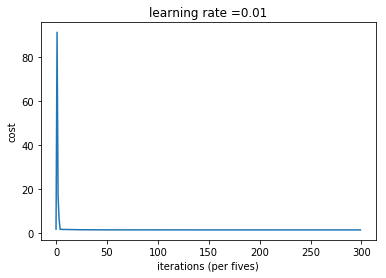

Train Accuracy: 0.32795656
Test Accuracy: 0.3282226


In [28]:
parameters = model(X_train, Y_train, X_test, Y_test, num_epochs=1500, minibatch_size=12337)
#1500 Epochs
#learning rate 0.01
#no reg
#größeres Netz [192,36,6]

cost after epoch 0: 1.550447
cost after epoch 100: 0.945095
cost after epoch 200: 0.805728
cost after epoch 300: 0.658550
cost after epoch 400: 0.600988
cost after epoch 500: 0.529342
cost after epoch 600: 0.493285
cost after epoch 700: 0.463908
cost after epoch 800: 0.444640
cost after epoch 900: 0.426148
cost after epoch 1000: 0.425389
cost after epoch 1100: 0.396989
cost after epoch 1200: 0.390841
cost after epoch 1300: 0.374346
cost after epoch 1400: 0.368151
cost after epoch 1500: 0.367320
cost after epoch 1600: 0.338222
cost after epoch 1700: 0.348841
cost after epoch 1800: 0.340408
cost after epoch 1900: 0.315061
cost after epoch 2000: 0.340020
cost after epoch 2100: 0.309464
cost after epoch 2200: 0.303752
cost after epoch 2300: 0.281604
cost after epoch 2400: 0.277047
cost after epoch 2500: 0.289599
cost after epoch 2600: 0.287982
cost after epoch 2700: 0.284418
cost after epoch 2800: 0.276083
cost after epoch 2900: 0.273663
cost after epoch 3000: 0.262541
cost after epoch 310

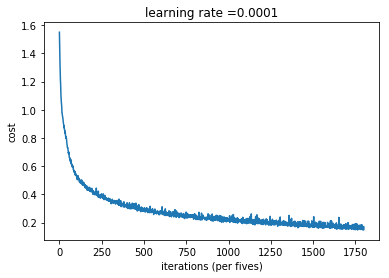

Train Accuracy: 0.94634026
Test Accuracy: 0.86428165


In [285]:
parameters = model(X_train, Y_train, X_test, Y_test, minibatch_size=64)
#9000 Epochs
#ohne reg [192,36,6]
#größeres Netz

cost after epoch 0: 1.550447
cost after epoch 100: 0.945095
cost after epoch 200: 0.805728
cost after epoch 300: 0.658550
cost after epoch 400: 0.600988
cost after epoch 500: 0.529342
cost after epoch 600: 0.493285
cost after epoch 700: 0.463908
cost after epoch 800: 0.444640
cost after epoch 900: 0.426148
cost after epoch 1000: 0.425389
cost after epoch 1100: 0.396989
cost after epoch 1200: 0.390841
cost after epoch 1300: 0.374346
cost after epoch 1400: 0.368151


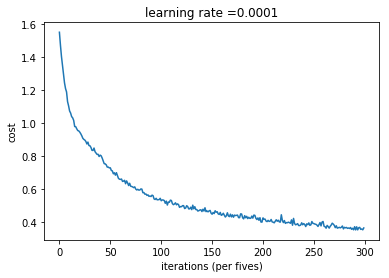

Train Accuracy: 0.8555564
Test Accuracy: 0.80579215


In [281]:
parameters = model(X_train, Y_train, X_test, Y_test, minibatch_size=64)
#1500 Epochs
#ohne reg [192,36,6]
#größeres Netz

cost after epoch 0: 2.441722
cost after epoch 100: 1.312130
cost after epoch 200: 1.225449
cost after epoch 300: 1.170698
cost after epoch 400: 1.158656
cost after epoch 500: 1.113091
cost after epoch 600: 1.098160
cost after epoch 700: 1.101883
cost after epoch 800: 1.085199
cost after epoch 900: 1.082908
cost after epoch 1000: 1.050980
cost after epoch 1100: 1.044125
cost after epoch 1200: 1.046966
cost after epoch 1300: 1.033045
cost after epoch 1400: 1.031124
cost after epoch 1500: 1.032798
cost after epoch 1600: 1.028355
cost after epoch 1700: 1.022605
cost after epoch 1800: 1.013703
cost after epoch 1900: 1.005484
cost after epoch 2000: 1.023363
cost after epoch 2100: 1.015469
cost after epoch 2200: 1.006194
cost after epoch 2300: 0.994929
cost after epoch 2400: 1.006846
cost after epoch 2500: 1.010232
cost after epoch 2600: 1.016191
cost after epoch 2700: 1.002007
cost after epoch 2800: 0.994372
cost after epoch 2900: 0.998236
cost after epoch 3000: 0.994887
cost after epoch 310

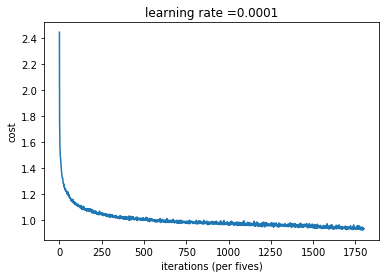

Train Accuracy: 0.6897139
Test Accuracy: 0.67404884


In [276]:
parameters = model(X_train, Y_train, X_test, Y_test, minibatch_size=64)
#9000 Epochs
#L2_regularization, beta=0.01

cost after epoch 0: 1.540146
cost after epoch 100: 0.990687
cost after epoch 200: 0.866600
cost after epoch 300: 0.786234
cost after epoch 400: 0.731951
cost after epoch 500: 0.650518
cost after epoch 600: 0.598913
cost after epoch 700: 0.564516
cost after epoch 800: 0.523987
cost after epoch 900: 0.497144
cost after epoch 1000: 0.479202
cost after epoch 1100: 0.459562
cost after epoch 1200: 0.447018
cost after epoch 1300: 0.426429
cost after epoch 1400: 0.411369
cost after epoch 1500: 0.418051
cost after epoch 1600: 0.381162
cost after epoch 1700: 0.389790
cost after epoch 1800: 0.370009
cost after epoch 1900: 0.373850
cost after epoch 2000: 0.379625
cost after epoch 2100: 0.345282
cost after epoch 2200: 0.349205
cost after epoch 2300: 0.328704
cost after epoch 2400: 0.324764
cost after epoch 2500: 0.325956
cost after epoch 2600: 0.320499
cost after epoch 2700: 0.326405
cost after epoch 2800: 0.320258
cost after epoch 2900: 0.315564
cost after epoch 3000: 0.313474
cost after epoch 310

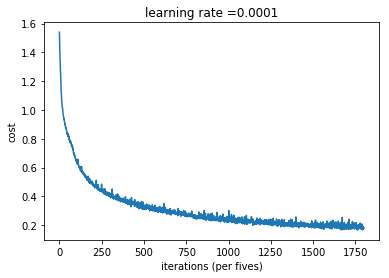

Train Accuracy: 0.93280375
Test Accuracy: 0.8557638


In [254]:
parameters = model(X_train, Y_train, X_test, Y_test, minibatch_size=64)
#9000 Epochs

cost after epoch 0: 1.540069
cost after epoch 100: 1.032328
cost after epoch 200: 0.894697
cost after epoch 300: 0.798220
cost after epoch 400: 0.735206
cost after epoch 500: 0.683162
cost after epoch 600: 0.654518
cost after epoch 700: 0.617622
cost after epoch 800: 0.584967
cost after epoch 900: 0.559017
cost after epoch 1000: 0.543884
cost after epoch 1100: 0.516826
cost after epoch 1200: 0.502889
cost after epoch 1300: 0.492385
cost after epoch 1400: 0.489167


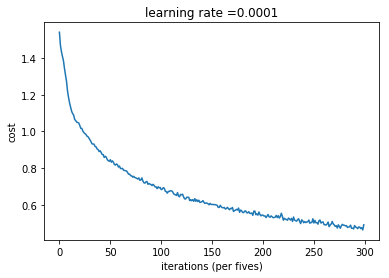

Train Accuracy: 0.81429845
Test Accuracy: 0.7569563


In [269]:
parameters = model(X_train, Y_train, X_test, Y_test, minibatch_size=64)
#1500 Epochs
#l2_regularization